# MICE Foreign Demand Time-Series Statistical Analysis

# 1. Introduction
This notebook presents an analysis of foreign MICE demand using time-series data from 2009 Q1 to 2019 Q4. The primary goal is to examine the relationships between economic indicators such as international oil prices, exchange rates, and MICE demand using statistical methods. This notebook was performed by Google Colab

In [ ]:
!pip install statsmodels linearmodels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2. Dataset Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

file_path = "/content/drive/My Drive/MICE/MICE_dataset_Foreigner.csv"
try:
  df = pd.read_csv(file_path, encoding= "cp949")
  print("File load sucess!")
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}. Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

File load sucess!


In [4]:
df.head()

,Year,Dubai_oil,Exchange_rate,Tourism_Foreigner,MICE_Foreigner,D_COVID
0,2009_1,392.98,1415.22,1998704,53044,0
1,2009_2,477.67,1288.68,1793651,172336,0
2,2009_3,530.06,1240.89,1983829,99308,0
3,2009_4,554.43,1168.61,2041349,125504,0
4,2010_1,546.54,1144.08,1978258,101903,0


# 3. Data preprosessing

In [5]:
import numpy as np
import pandas as pd

log_cols = ['Dubai_oil', 'Exchange_rate', 'Tourism_Foreigner', 'MICE_Foreigner']
for col in log_cols:
    df[f'ln_{col}'] = np.log(df[col])

In [6]:
df[[f'ln_{col}' for col in log_cols]].head()

,ln_Dubai_oil,ln_Exchange_rate,ln_Tourism_Foreigner,ln_MICE_Foreigner
0,5.973759,7.255040,14.508010,10.878877
1,6.168920,7.161374,14.399764,12.057201
2,6.272990,7.123584,14.500539,11.505981
3,6.317941,7.063570,14.529121,11.740093
4,6.303607,7.042356,14.497727,11.531777


To minimize the impact of structural breaks, the data was parsed to include only pre-COVID (prior to Q1 2020) observations.

In [7]:
df_pre_covid = df[df['Year'] < '2020_1'].copy()

In [8]:
df_pre_covid.tail()

,Year,Dubai_oil,Exchange_rate,Tourism_Foreigner,MICE_Foreigner,D_COVID,ln_Dubai_oil,ln_Exchange_rate,ln_Tourism_Foreigner,ln_MICE_Foreigner
39,2018_4,481.46,1127.52,4202341,473856,0,6.176823,7.027776,15.251152,13.068659
40,2019_1,448.43,1125.08,3842246,330000,0,6.105753,7.025609,15.161568,12.706848
41,2019_2,495.52,1165.91,4596968,490000,0,6.205608,7.061257,15.340908,13.102161
42,2019_3,458.26,1193.24,4494030,420000,0,6.127437,7.084428,15.318260,12.948010
43,2019_4,458.95,1175.81,4569512,500000,1,6.128941,7.069713,15.334917,13.122363


# 4. Statistical Tests and Models Used

4.1. ADF (Augmented Dickey-Fuller) Test

The ADF test is performed to check for the stationarity of the time series data. Non-stationary data may need differencing before being analyzed further.

In [9]:
from statsmodels.tsa.stattools import adfuller

# List of Logarithmic Variables for ADF Test
log_cols = ['ln_Dubai_oil', 'ln_Exchange_rate', 'ln_Tourism_Foreigner', 'ln_MICE_Foreigner']

# ADF Test
for col in log_cols:
    result = adfuller(df_pre_covid[col].dropna())
    print(f"ADF Test Result for {col}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.10f}\n")

ADF Test Result for ln_Dubai_oil
ADF Statistic: -1.4488
p-value: 0.5586493484

ADF Test Result for ln_Exchange_rate
ADF Statistic: -4.8804
p-value: 0.0000380759

ADF Test Result for ln_Tourism_Foreigner
ADF Statistic: -1.2775
p-value: 0.6393945526

ADF Test Result for ln_MICE_Foreigner
ADF Statistic: -3.6783
p-value: 0.0044292650



In [10]:
# Variables to be differenced
log_cols = ['ln_Dubai_oil', 'ln_Exchange_rate', 'ln_Tourism_Foreigner', 'ln_MICE_Foreigner']

# First-order differencing
df_diff = df_pre_covid[['Year']].copy()  # Year is Retained
for col in log_cols:
    df_diff[f'd_{col}'] = df_pre_covid[col].diff()

In [11]:
df_diff.head()

,Year,d_ln_Dubai_oil,d_ln_Exchange_rate,d_ln_Tourism_Foreigner,d_ln_MICE_Foreigner
0,2009_1,NaN,NaN,NaN,NaN
1,2009_2,0.195161,-0.093667,-0.108246,1.178324
2,2009_3,0.104070,-0.037790,0.100776,-0.551220
3,2009_4,0.044950,-0.060014,0.028582,0.234111
4,2010_1,-0.014333,-0.021214,-0.031394,-0.208316


In [12]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    44 non-null     object 
 1   d_ln_Dubai_oil          43 non-null     float64
 2   d_ln_Exchange_rate      43 non-null     float64
 3   d_ln_Tourism_Foreigner  43 non-null     float64
 4   d_ln_MICE_Foreigner     43 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [13]:
from statsmodels.tsa.stattools import adfuller

# List of First-Order Differenced Variables
diff_cols = [f'd_ln_{col}' for col in ['Dubai_oil', 'Tourism_Foreigner']]

# Perform ADF Test
for col in diff_cols:
    series = df_diff[col].dropna()
    result = adfuller(series)
    print(f"ADF First-Order Differencing Result for {col}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.10f}\n")

ADF First-Order Differencing Result for d_ln_Dubai_oil
ADF Statistic: -6.3048
p-value: 0.0000000334

ADF First-Order Differencing Result for d_ln_Tourism_Foreigner
ADF Statistic: -5.2439
p-value: 0.0000071490



Among the level variables, exchange rates and foreign MICE demand were found to be stationary in their log-transformed state. However, international oil prices and foreign tourist demand exhibited non-stationarity. After first-order differencing, the unit root tests passed the critical values at the 1% significance level, indicating that the series became stationary.

4.2. Johansen Cointegration Test

This test checks whether there are long-term relationships between the variables, which is important when dealing with time-series data.

In [14]:
df_pre_covid.head()

,Year,Dubai_oil,Exchange_rate,Tourism_Foreigner,MICE_Foreigner,D_COVID,ln_Dubai_oil,ln_Exchange_rate,ln_Tourism_Foreigner,ln_MICE_Foreigner
0,2009_1,392.98,1415.22,1998704,53044,0,5.973759,7.255040,14.508010,10.878877
1,2009_2,477.67,1288.68,1793651,172336,0,6.168920,7.161374,14.399764,12.057201
2,2009_3,530.06,1240.89,1983829,99308,0,6.272990,7.123584,14.500539,11.505981
3,2009_4,554.43,1168.61,2041349,125504,0,6.317941,7.063570,14.529121,11.740093
4,2010_1,546.54,1144.08,1978258,101903,0,6.303607,7.042356,14.497727,11.531777


In [15]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Extract Relevant Log-Level Data → Cointegration is Performed at the Log Level
johansen_df = df_pre_covid[['ln_Dubai_oil', 'ln_Exchange_rate', 'ln_Tourism_Foreigner', 'ln_MICE_Foreigner']].dropna()

In [16]:
johansen_df.head()

,ln_Dubai_oil,ln_Exchange_rate,ln_Tourism_Foreigner,ln_MICE_Foreigner
0,5.973759,7.255040,14.508010,10.878877
1,6.168920,7.161374,14.399764,12.057201
2,6.272990,7.123584,14.500539,11.505981
3,6.317941,7.063570,14.529121,11.740093
4,6.303607,7.042356,14.497727,11.531777


In [17]:
# Perform Johansen Cointegration Test
# det_order = -1: Automatic, 0: No constant, 1: Constant included, 2: Trend included
# k_ar_diff: Specify differencing lag (VAR lag). Typically estimated using AIC or set to 1-2

johan_result = coint_johansen(johansen_df, det_order=1, k_ar_diff=1)

In [18]:
# Summarize the Results

johansen_summary = pd.DataFrame({
    'Eigenvalue': johan_result.eig,
    'Trace Statistic': johan_result.lr1,
    'Critical Value (90%)': johan_result.cvt[:, 0],
    'Critical Value (95%)': johan_result.cvt[:, 1],
    'Critical Value (99%)': johan_result.cvt[:, 2]
}, index=[f'r <= {i}' for i in range(len(johan_result.eig))])

In [19]:
johansen_summary

,Eigenvalue,Trace Statistic,Critical Value (90%),Critical Value (95%),Critical Value (99%)
r <= 0,0.369123,39.759713,51.6492,55.2459,62.5202
r <= 1,0.264595,20.412654,32.0645,35.0116,41.0815
r <= 2,0.112955,7.504632,16.1619,18.3985,23.1485
r <= 3,0.057125,2.470509,2.7055,3.8415,6.6349


The Johansen cointegration test was performed to examine the long-term equilibrium relationships between the variables. The test results showed that the trace statistics for all vector ranks were smaller than the critical values at the 90%, 95%, and 99% significance levels, indicating that no cointegration relationship exists among the variables. Therefore, the inability to identify long-term equilibrium relationships suggests that the VAR model is more suitable than the Vector Error Correction Model (VECM) for this analysis.

4.4. VAR Model

The VAR model helps analyze the dynamic interaction between multiple time series.

In [20]:
var_cols = ['ln_Dubai_oil', 'ln_Exchange_rate', 'ln_Tourism_Foreigner', 'ln_MICE_Foreigner']

In [21]:
# Generate Differenced Data and Remove the First Column
df_diff = df_pre_covid[var_cols].diff().dropna()

In [22]:
df_diff.head()

,ln_Dubai_oil,ln_Exchange_rate,ln_Tourism_Foreigner,ln_MICE_Foreigner
1,0.195161,-0.093667,-0.108246,1.178324
2,0.104070,-0.037790,0.100776,-0.551220
3,0.044950,-0.060014,0.028582,0.234111
4,-0.014333,-0.021214,-0.031394,-0.208316
5,0.041836,0.016798,0.096262,0.403478


In [ ]:
# Fit the VAR Model
from statsmodels.tsa.api import VAR
model = VAR(df_diff)
var_result = model.fit(maxlags=5, ic='aic')

In [24]:
# Summarize the Results
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     05:01:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -17.4985
Nobs:                     42.0000    HQIC:                  -18.0227
Log likelihood:           166.464    FPE:                1.10430e-08
AIC:                     -18.3260    Det(Omega_mle):     7.04195e-09
--------------------------------------------------------------------
Results for equation ln_Dubai_oil
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.000159         0.021036           -0.008           0.994
L1.ln_Dubai_oil                 0.010056         0.171623            0.059           0.953
L1.ln_Exchang

The VAR model analysis results indicated that only the autoregressive coefficient for foreign MICE demand was statistically significant, while the other variables were found to be non-significant.

4.5. Impulse Response Function (IRF)

The IRF analyzes how a shock to one variable affects other variables over time.

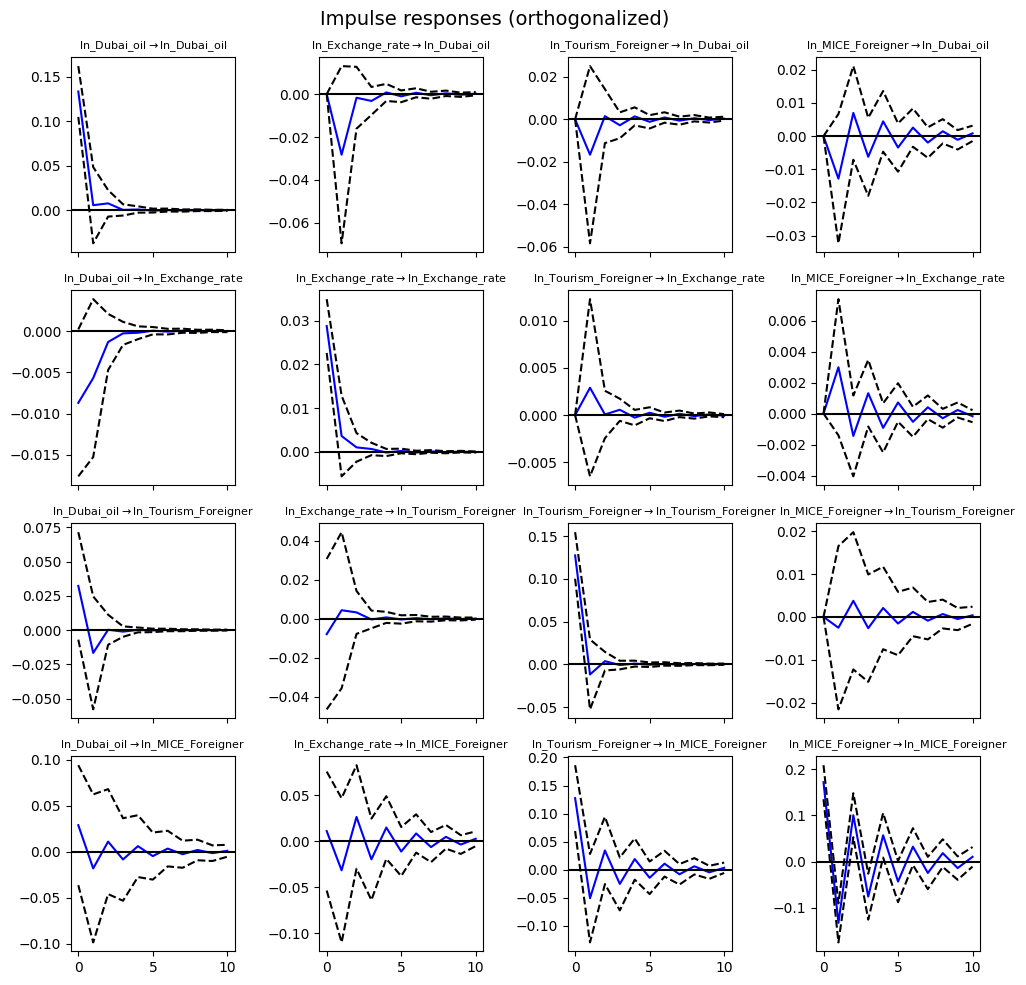

In [25]:
import matplotlib.pyplot as plt

# Calculate and Visualize Impulse Response Function (IRF)
irf = var_result.irf(10)  # 10 period까지 반응 추적

fig = irf.plot(orth=True)

# Adjust Font Size Globally
for ax in fig.axes:
    ax.title.set_fontsize(8)

# Handle Line Breaks
for ax in fig.axes:
    title = ax.get_title()
    if '→' in title:
        ax.set_title(title.replace('→', '\n→'), fontsize=8)

plt.tight_layout()
plt.show()

The most prominent response was observed when foreign tourist demand shocked MICE tourist demand. Following the shock, MICE tourist demand responded strongly in a positive direction for 1-2 periods before gradually decreasing, showing statistically significant reactions. This suggests that an increase in general tourist demand has a tangible impact on foreign MICE demand. Similarly, a shock to foreign MICE demand also led to a significant positive response in foreign tourist demand, indicating a bidirectional complementarity between the two. On the other hand, shocks to international oil prices induced a clear negative short-term response in both tourism and MICE demand. The shock from exchange rates resulted in relatively small responses across all variables, suggesting that foreign tourism and MICE demand are relatively insensitive to short-term exchange rate fluctuations.

4.6. Forecast Error Variance Decomposition (FEVD)

FEVD explains how much of the forecast error variance is explained by each variable.

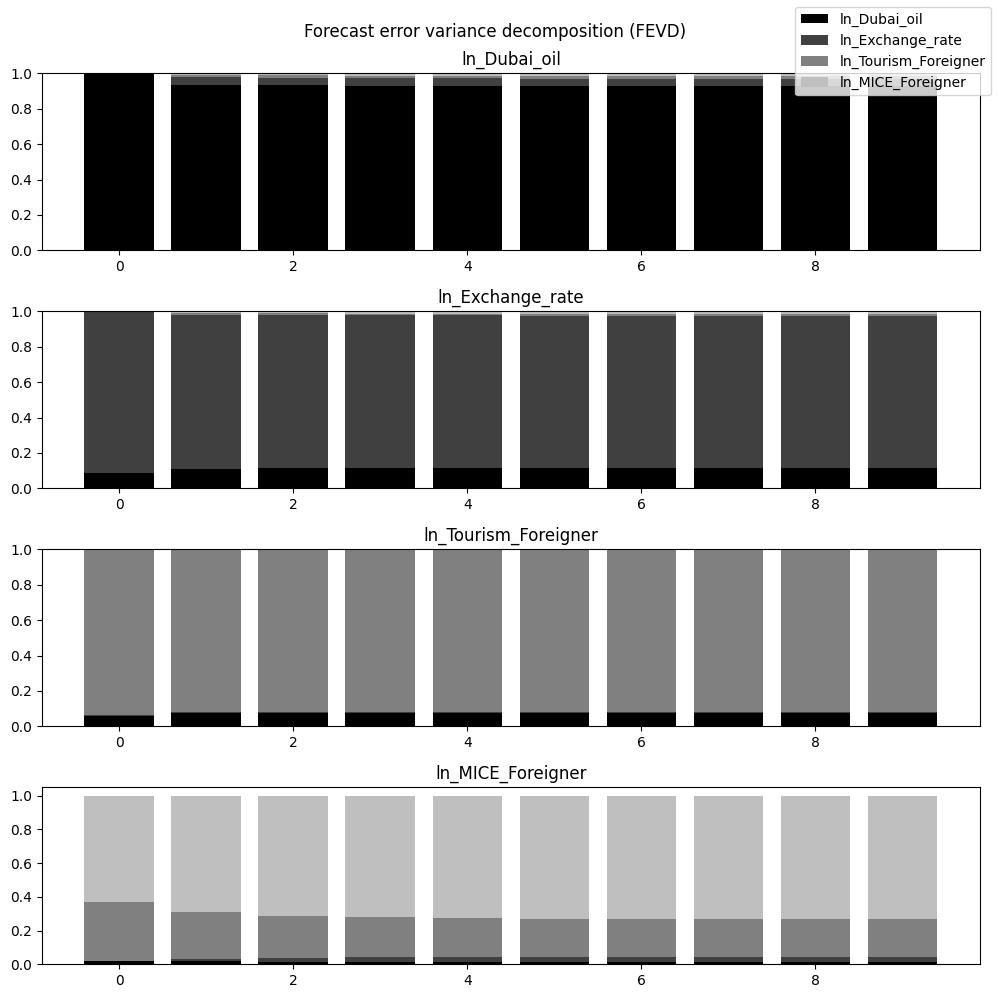

In [26]:
# Forecast Error Decomposition (Contribution of Each Variable's Forecast Error)
fevd = var_result.fevd(10) # Decompose up to 10 periods

# Visualize Decomposition Results for All Variables
fevd.plot()
plt.tight_layout()
plt.show()

# If to view contributions for a specific variable:
# fevd.plot(variable='ln_MICE_Foreigner')

The results of the Forecast Error Variance Decomposition (FEVD) showed that most of the forecast error in international oil prices is explained by its own shocks, indicating that it behaves as an exogenous variable. For the exchange rate variable, initially, the influence of international oil prices was minimal, but over time, the explanatory power of its own shocks became dominant. The demand for foreign tourists showed a small influence from international oil prices, but most of the forecast error was explained by its own shocks. Similarly, the foreign MICE demand variable showed high explanatory power from its own shocks, though the influence of other variables was the most complex.